In [1]:
# Import necessary packages
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

os.chdir("/home/maina/Documents/Air Pollution Monitoring")

# import data_retrival and analysis functions
from data_analysis import *

2022-01-12 16:15:34.967446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 16:15:34.967472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Gets the data from firebase, process it and store it in a csv file
filepath = read_data()

# Read the dataset as a pandas dataframe
df = pd.read_csv(filepath)

# Display the first 10 rows
df.head(10)

,timestamp,mq7,mq135,temperature,humidity
0,1639922725,162.0,39.0,24.1,73.0
1,1639923325,135.0,38.0,23.9,75.0
2,1639923927,118.0,36.0,24.0,72.0
3,1639924555,109.0,39.0,24.4,73.0
4,1639925428,102.0,42.0,24.2,74.0
5,1639926056,100.0,42.0,24.2,76.0
6,1639926658,97.0,40.0,24.2,75.0
7,1639927411,96.0,37.0,24.0,77.0
8,1639928191,92.0,37.0,23.9,77.0
9,1639928791,92.0,37.0,23.9,77.0


In [3]:
# Converting the unix time stamp to datetime format
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df["timestamp"] = df["timestamp"].dt.tz_localize('Africa/Nairobi')
df.head()

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0


In [4]:
# Resapmle dataset hourly using mean
raw_df = df.set_index("timestamp")
df = raw_df.resample(rule='H').mean()
df.head()

,mq7,mq135,temperature,humidity
timestamp,,,,
2021-12-19 14:00:00+03:00,125.200000,38.800000,24.120000,73.400000
2021-12-19 15:00:00+03:00,95.000000,38.500000,23.983333,76.666667
2021-12-19 16:00:00+03:00,90.166667,36.166667,23.266667,77.666667
2021-12-19 17:00:00+03:00,97.200000,39.800000,23.240000,78.400000
2021-12-19 18:00:00+03:00,95.500000,39.500000,23.233333,79.833333


In [5]:
# Check if there are any missing values in the dataset
df.isnull().sum()

mq7            0
mq135          0
temperature    0
humidity       0
dtype: int64

In [6]:
# Statistical summary of the dataset columns
df.describe()

,mq7,mq135,temperature,humidity
count,352.000000,352.000000,352.000000,352.000000
mean,87.077023,42.029334,24.492894,62.310476
std,13.675241,7.418984,2.496454,10.194331
min,51.750000,27.833333,21.012821,29.800000
25%,79.437500,38.250000,22.991667,58.005357
50%,84.400000,40.200000,23.837500,66.055000
75%,91.312500,43.350000,25.227841,67.862672
max,153.166667,88.500000,34.000000,81.333333


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

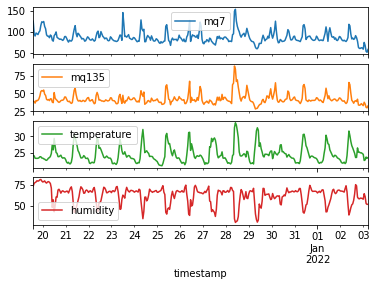

In [7]:
# plot the values against time
df[["mq7", "mq135", "temperature", "humidity"]].plot(subplots=True)

In [8]:
scaler = MinMaxScaler()
df.reset_index(inplace=True)
scaled_data = scaler.fit_transform(df.drop("timestamp", axis=1))

In [37]:
x = scaled_data
y = scaled_data[:,1]
# y = scaled_data[:,0:2]


print(x.shape, y.shape)

(352, 4) (352,)


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(281, 4) (71, 4) (281,) (71,)


In [39]:
window_length = 5
num_features = 4
batch_size = 16
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [40]:
train_generator[0]

(array([[[0.72423993, 0.18076923, 0.23924975, 0.84605433],
         [0.4264585 , 0.17582418, 0.22872655, 0.90944373],
         [0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263]],
 
        [[0.4264585 , 0.17582418, 0.22872655, 0.90944373],
         [0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263],
         [0.41166804, 0.2032967 , 0.17354393, 0.96119017]],
 
        [[0.37880033, 0.13736264, 0.17354393, 0.92884864],
         [0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0.97089263],
         [0.41166804, 0.2032967 , 0.17354393, 0.96119017],
         [0.46918652, 0.23626374, 0.18381046, 0.97089263]],
 
        [[0.44815119, 0.19725275, 0.17149062, 0.94307891],
         [0.43138866, 0.19230769, 0.1709773 , 0

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(window_length, num_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 128)            68096     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 5, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 128)            131584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 5, 128)            0         
                                                                 
 dropout_4 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)            

In [42]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
                              )

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [43]:
history = model.fit_generator(
    train_generator, 
    epochs=100,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping]
                             )

Epoch 1/100


/tmp/ipykernel_92631/1192819614.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


18/18 [==============================] - 5s 75ms/step - loss: 0.0392 - mae: 0.1591 - val_loss: 0.0184 - val_mae: 0.1050
Epoch 2/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0252 - mae: 0.1091 - val_loss: 0.0153 - val_mae: 0.0940
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0216 - mae: 0.1013 - val_loss: 0.0126 - val_mae: 0.0796
Epoch 4/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0190 - mae: 0.0918 - val_loss: 0.0121 - val_mae: 0.0800
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0179 - mae: 0.0878 - val_loss: 0.0118 - val_mae: 0.0799
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0174 - mae: 0.0864 - val_loss: 0.0114 - val_mae: 0.0780
Epoch 7/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0168 - mae: 0.0850 - val_loss: 0.0110 - val_mae: 0.0753
Epoch 8/100
18/18 [==============================] - 0s 16ms/step - loss: 0.0166 - mae: 

In [44]:
model.evaluate(test_generator, verbose=0)

[0.010229215025901794, 0.07130304723978043]

In [45]:
preds = model.predict_generator(test_generator)
preds = preds.reshape(66, window_length)
print(preds.shape)
preds[:,0]

/tmp/ipykernel_92631/2852816128.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


(66, 5)


array([0.22929761, 0.22879742, 0.253531  , 0.2564823 , 0.2482674 ,
       0.22301602, 0.22455539, 0.2292638 , 0.23654853, 0.23930945,
       0.23551969, 0.23388787, 0.23273088, 0.23265879, 0.23294716,
       0.2348226 , 0.24061589, 0.23833588, 0.2350524 , 0.23325564,
       0.2339888 , 0.23372123, 0.23206627, 0.23065229, 0.23499542,
       0.23996231, 0.247939  , 0.23344953, 0.22108147, 0.23660399,
       0.23879673, 0.23507312, 0.23324016, 0.23620147, 0.23845346,
       0.2348306 , 0.23455429, 0.23133622, 0.23257811, 0.23604111,
       0.24083374, 0.23962297, 0.23647575, 0.23339339, 0.23210718,
       0.23291674, 0.23183198, 0.23124523, 0.22910614, 0.22632985,
       0.25822946, 0.25636452, 0.236542  , 0.2231224 , 0.2232654 ,
       0.22258702, 0.2306137 , 0.2396019 , 0.23610647, 0.22851141,
       0.21452191, 0.21303962, 0.21448313, 0.2167749 , 0.21494447,
       0.2125063 ], dtype=float32)

In [46]:
x_test[:,1:][window_length:]

array([[0.21043956, 0.46716683, 0.40750323],
       [0.19230769, 0.41865745, 0.42739327],
       [0.17417582, 0.33626851, 0.56778784],
       [0.20879121, 0.24925962, 0.7373868 ],
       [0.19725275, 0.1807305 , 0.86274256],
       [0.18406593, 0.21653504, 0.81161061],
       [0.20054945, 0.22538993, 0.74359638],
       [0.20054945, 0.21846002, 0.72137775],
       [0.20054945, 0.19921027, 0.72574386],
       [0.20054945, 0.18573544, 0.72574386],
       [0.21703297, 0.17996051, 0.72622898],
       [0.26318681, 0.1653307 , 0.71681759],
       [0.2532967 , 0.12991115, 0.68615783],
       [0.21703297, 0.07601185, 0.70827943],
       [0.19230769, 0.05483712, 0.72574386],
       [0.21043956, 0.07755183, 0.69741268],
       [0.19230769, 0.06831194, 0.72816947],
       [0.16428571, 0.08987167, 0.75989651],
       [0.1510989 , 0.13568608, 0.75582147],
       [0.23351648, 0.28698914, 0.63027167],
       [0.31593407, 0.4148075 , 0.50776197],
       [0.48406593, 0.71048371, 0.24489004],
       [0.

In [47]:
df_pred = pd.concat([pd.DataFrame(preds[:,0]), pd.DataFrame(x_test[:,1:][window_length:])], axis=1)
df_pred

,0,0,1,2
0,0.229298,0.210440,0.467167,0.407503
1,0.228797,0.192308,0.418657,0.427393
2,0.253531,0.174176,0.336269,0.567788
3,0.256482,0.208791,0.249260,0.737387
4,0.248267,0.197253,0.180731,0.862743
...,...,...,...,...
61,0.213040,0.157692,0.122211,0.669082
62,0.214483,0.115385,0.135044,0.601552
63,0.216775,0.039835,0.202098,0.440492
64,0.214944,0.027473,0.174186,0.421087


In [48]:
reverse_transform = scaler.inverse_transform(df_pred)

In [49]:
reverse_transform

array([[75.00459909, 40.6       , 27.08      , 50.8       ],
       [74.95387177, 39.5       , 26.45      , 51.825     ],
       [77.46226983, 38.4       , 25.38      , 59.06      ],
       [77.76158024, 40.5       , 24.25      , 67.8       ],
       [76.92845187, 39.8       , 23.36      , 74.26      ],
       [74.36754173, 39.        , 23.825     , 71.625     ],
       [74.52365894, 40.        , 23.94      , 68.12      ],
       [75.00117012, 40.        , 23.85      , 66.975     ],
       [75.73996322, 40.        , 23.6       , 67.2       ],
       [76.01996622, 40.        , 23.425     , 67.2       ],
       [75.63562213, 41.        , 23.35      , 67.225     ],
       [75.47012776, 43.8       , 23.16      , 66.74      ],
       [75.35279012, 43.2       , 22.7       , 65.16      ],
       [75.34547881, 41.        , 22.        , 66.3       ],
       [75.37472405, 39.5       , 21.725     , 67.2       ],
       [75.56492546, 40.6       , 22.02      , 65.74      ],
       [76.15246145, 39.

In [50]:
scaled_data[:,0:2]

array([[0.72423993, 0.18076923],
       [0.4264585 , 0.17582418],
       [0.37880033, 0.13736264],
       [0.44815119, 0.19725275],
       [0.43138866, 0.19230769],
       [0.41166804, 0.2032967 ],
       [0.46918652, 0.23626374],
       [0.49794577, 0.30357143],
       [0.62530813, 0.40659341],
       [0.70912079, 0.42857143],
       [0.69597371, 0.41758242],
       [0.71635168, 0.44120879],
       [0.60197206, 0.3456044 ],
       [0.54806902, 0.31593407],
       [0.40673788, 0.22527473],
       [0.37551356, 0.20879121],
       [0.37518488, 0.22032967],
       [0.33935908, 0.19505495],
       [0.40180772, 0.23763736],
       [0.38110107, 0.23351648],
       [0.28249795, 0.16098901],
       [0.2588332 , 0.14697802],
       [0.38701726, 0.38186813],
       [0.41857025, 0.2532967 ],
       [0.47329499, 0.22115385],
       [0.34757601, 0.20054945],
       [0.33032046, 0.1717033 ],
       [0.31405094, 0.1543956 ],
       [0.30073952, 0.16758242],
       [0.30813476, 0.19395604],
       [0.

In [51]:
df_final = raw_df[preds.shape[0]*-1:]
df_final.count()

mq7            66
mq135          66
temperature    66
humidity       66
dtype: int64

In [52]:
df_final["mq7_Predicted"] = reverse_transform[:,0]
df_final

/tmp/ipykernel_92631/258616261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["mp7_Predicted"] = reverse_transform[:,0]


,mq7,mq135,temperature,humidity,mp7_Predicted
timestamp,,,,,
2022-01-02 18:21:38+03:00,82.0,45.0,28.9,54.0,75.004599
2022-01-02 18:35:22+03:00,69.0,35.0,24.6,62.1,74.953872
2022-01-02 18:51:25+03:00,72.0,36.0,24.3,64.1,77.462270
2022-01-02 18:59:30+03:00,61.0,33.0,25.7,56.0,77.761580
2022-01-02 19:14:23+03:00,78.0,38.0,23.7,68.2,76.928452
...,...,...,...,...,...
2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0,73.355768
2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0,73.502164
2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0,73.734587


<AxesSubplot:xlabel='timestamp'>

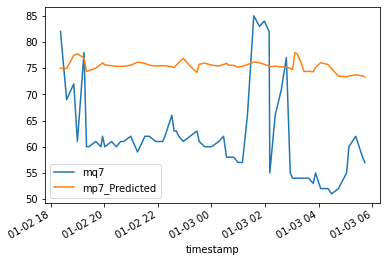

In [53]:
df_final[["mq7", "mq7_Predicted"]].plot(subplots=False)